In [36]:
#Load the libraries necessary to run the code
import os
import cv2
import glob
import torch
import datetime
import numpy as np
from PIL import Image
import glob
import torch.nn as nn
import albumentations as A
from torch import from_numpy
import torch.nn.functional as F
from torch.nn import DataParallel
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader

In [95]:
#Parameters

INPUT_IMG_SIZE = 1024

OUTPUT_CLASSES = 12

LEARINING_RATE = 0.01

OPIMIZER_NAME = 'Adam'
    
SCHEDULER_NAME = 'stepLR'

BATCH_SIZE = 8

MAX_EPOCHS = 10

AUGMENTATION = False 

MEAN = (0.485, 0.456, 0.406)

STD = (0.229, 0.224, 0.225)

MEAN = (0.5,0.5,0.5) 

STD = (0.5,0.5,0.5) 

MEAN = None

STD = None 

THRESH_ACC_CKP = 0.9

SCHEDULER_STEP_SIZE = 4

USE_CUDA = torch.cuda.is_available()

In [38]:
# This pulls the images from the path you set. It will need to be changed based on your own computers file locations.
# You need to place all images in a singular folder for this to work. It will not look inside other folders, all the image
# files need to be available, no sub-folders.

train_images = glob.glob(r'C:\Users\barto\Desktop\Advanced Machine Learning\Final Project\images\train/*.png')
test_images = glob.glob(r'C:\Users\barto\Desktop\Advanced Machine Learning\Final Project\images\test/*.png')

In [39]:
train_images

['C:\\Users\\barto\\Desktop\\Advanced Machine Learning\\Final Project\\images\\train\\aachen_000000_000019_leftImg8bit.png',
 'C:\\Users\\barto\\Desktop\\Advanced Machine Learning\\Final Project\\images\\train\\aachen_000001_000019_leftImg8bit.png',
 'C:\\Users\\barto\\Desktop\\Advanced Machine Learning\\Final Project\\images\\train\\aachen_000002_000019_leftImg8bit.png',
 'C:\\Users\\barto\\Desktop\\Advanced Machine Learning\\Final Project\\images\\train\\aachen_000003_000019_leftImg8bit.png',
 'C:\\Users\\barto\\Desktop\\Advanced Machine Learning\\Final Project\\images\\train\\aachen_000004_000019_leftImg8bit.png',
 'C:\\Users\\barto\\Desktop\\Advanced Machine Learning\\Final Project\\images\\train\\aachen_000005_000019_leftImg8bit.png',
 'C:\\Users\\barto\\Desktop\\Advanced Machine Learning\\Final Project\\images\\train\\aachen_000006_000019_leftImg8bit.png',
 'C:\\Users\\barto\\Desktop\\Advanced Machine Learning\\Final Project\\images\\train\\aachen_000007_000019_leftImg8bit.png',


In [40]:
# Used for testing on a small group of photos.

#small_test_images = glob.glob(r'C:\Users\Christian\Desktop\Classes\Advance Machine Learning\Project\DataSets\Real_Images\test\Small_Test/*.png')
small_test_images = train_images[:20]

In [41]:
# Sets the train and test lists.

# train_files = train_images
# test_files = test_images

train_files = small_test_images
test_files = small_test_images

print('Total train images:', len(train_files)) 
print('Total test images:', len(test_files))

Total train images: 12
Total test images: 12


In [45]:
# Mask Encoding
from tqdm import tqdm

kmeans_data = []
for i in tqdm(train_files[:50]):
    org_img = cv2.imread(i)
    #img = org_img[:, 0:INPUT_IMG_SIZE,:]
    msk = org_img[:, INPUT_IMG_SIZE:,:]
    kmeans_data.append(msk)
kmeans_data = np.array(kmeans_data)
kmeans_data = kmeans_data.reshape(-1,3)
print(kmeans_data.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 14.71it/s]

(22020096, 3)


In [46]:
# train kmeans with 12 clusters

encoder = KMeans(n_clusters = OUTPUT_CLASSES)
encoder.fit(kmeans_data)

KMeans(n_clusters=12)

In [47]:
colors = {0: [0, 255, 255], 
          1: [138, 43, 226],
          2: [156, 102, 31],
          3: [255, 153, 18],
          4: [255, 248, 220],
          5: [202, 255, 112],
          6: [255, 215, 0],
          7: [8, 8, 8],
          8: [255, 105, 180],
          9: [230, 230, 250],
          10: [238, 0, 0],
          11: [139, 139, 0]
          }

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

No of classes in encoded mask: [  0   8  18  31  43 102 105 112 138 139 153 156 180 202 215 220 226 230
 238 248 250 255]


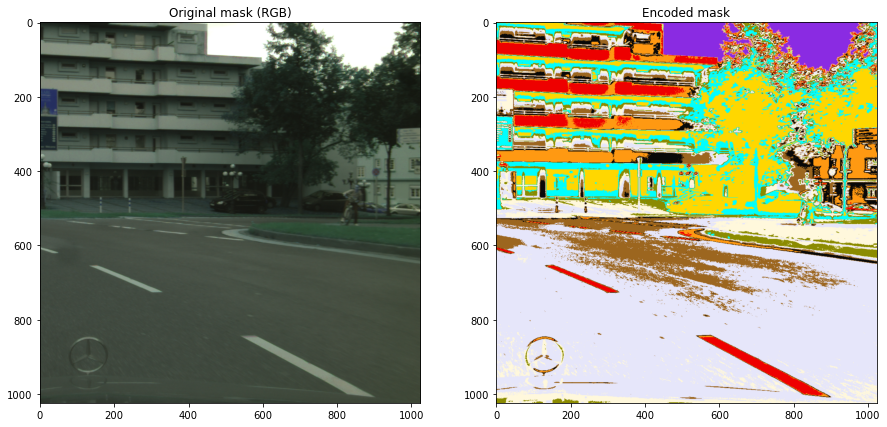

 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.88s/it]

No of classes in encoded mask: [  0   8  18  31  43 102 105 112 138 139 153 156 180 202 215 220 226 230
 238 248 250 255]


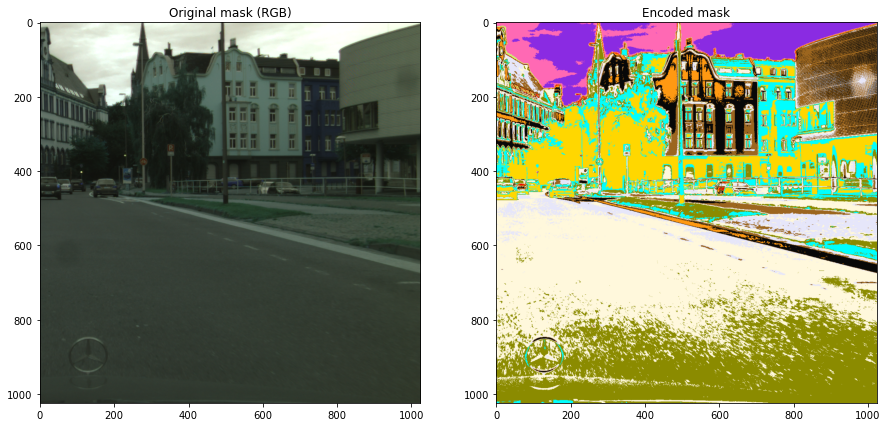

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:03<00:01,  1.94s/it]

No of classes in encoded mask: [  0   8  18  31  43 102 105 112 138 139 153 156 180 202 215 220 226 230
 238 248 250 255]


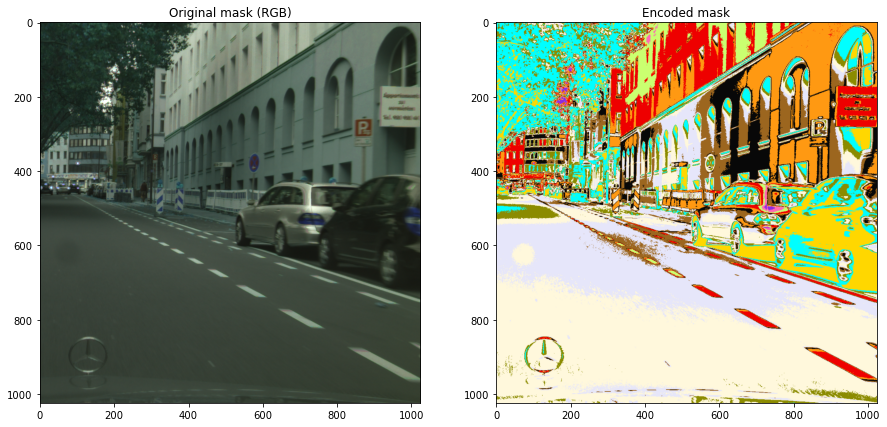

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.90s/it]


In [49]:
# encoding with trained kmeans

segmented_images = []
for i in tqdm(train_files[:3]):
    org_img = cv2.imread(i)
    #img = org_img[:, 0:256,:]
    msk = org_img[:, 1024:,:]      #shape (256,256,3)
    test = msk.reshape(-1,3)      #shape (65536,3)
    
    
    pred = encoder.predict(test)  #shape (65536)
    
    
    pred = np.array([colors[p] for p in pred]).reshape(1024, 1024, 3) #1024 x 1024 images with 3 rgb
    
    enc_pred = pred.reshape(1024, 1024, -1)  #shape (256,256)
    
    segmented_images.append(enc_pred)
    
    print('No of classes in encoded mask:',np.unique(enc_pred))
    
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(msk)
    plt.title('Original mask (RGB)')
    plt.subplot(1,2,2)
    plt.imshow(enc_pred)
    plt.title('Encoded mask')
    plt.show()

No of classes in encoded mask: [  0   8  43 112 138 202 215 226 230 238 250 255]


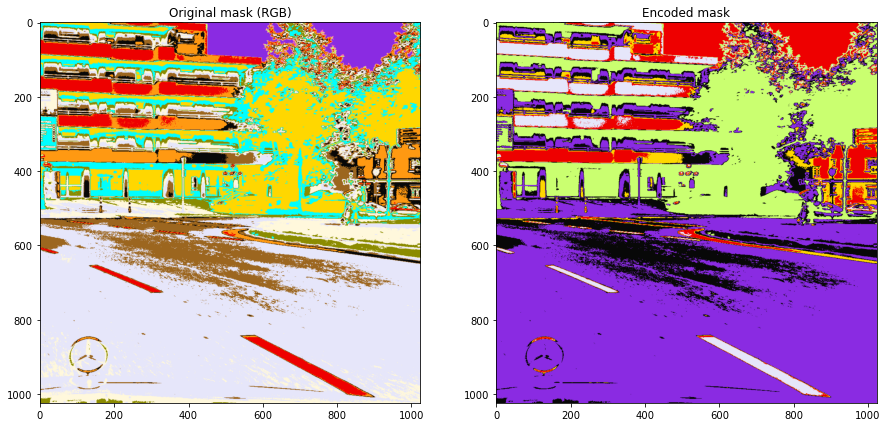

No of classes in encoded mask: [  0   8  43 112 138 202 215 226 230 238 250 255]


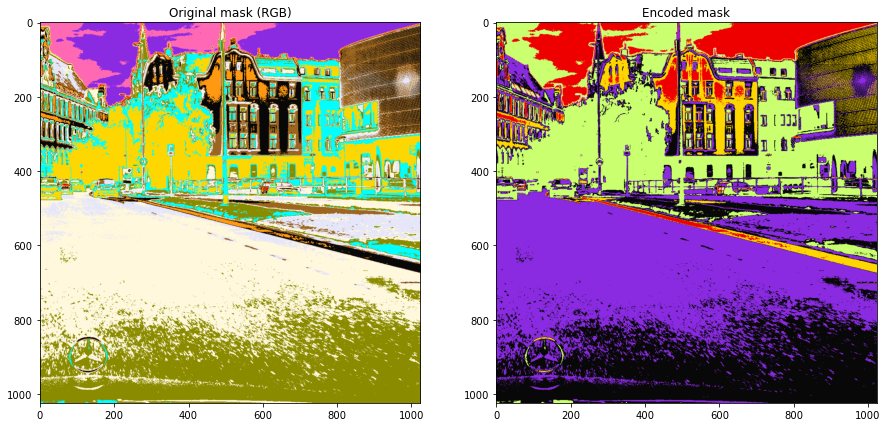

No of classes in encoded mask: [  0   8  43 112 138 202 215 226 230 238 250 255]


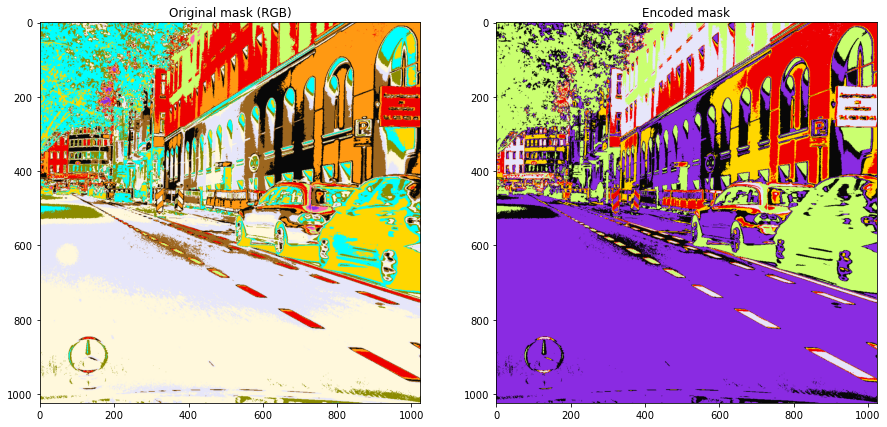

No of classes in encoded mask: [  0  43 112 138 202 215 226 230 238 250 255]


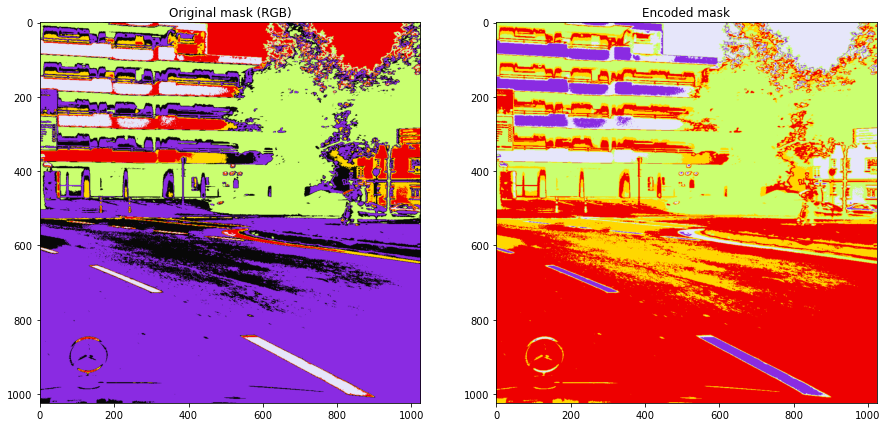

No of classes in encoded mask: [  0  43 112 138 202 215 226 230 238 250 255]


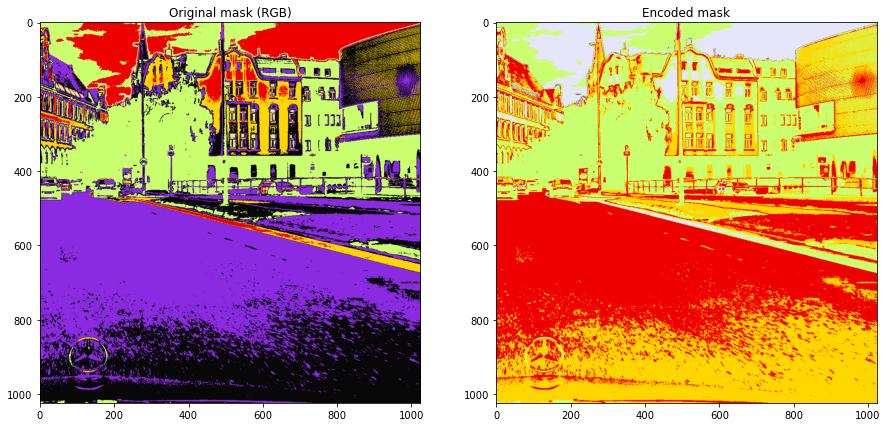

No of classes in encoded mask: [  0  43 112 138 202 215 226 230 238 250 255]


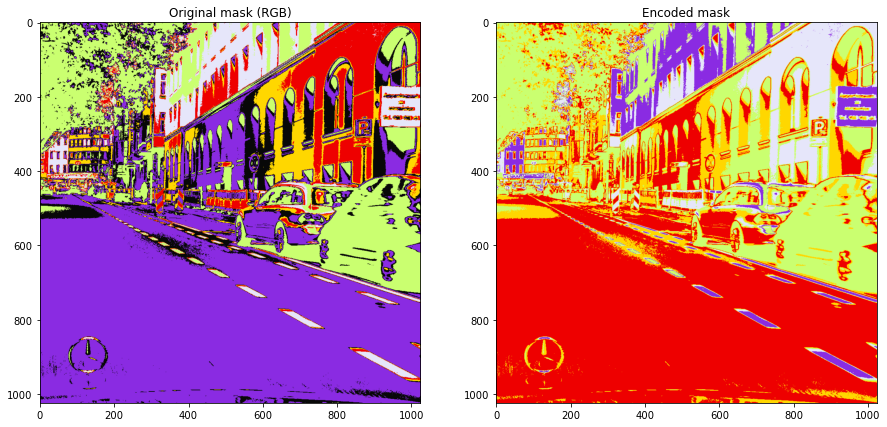

In [74]:
for i in range(len(segmented_images)):

    org_img = np.array(segmented_images[i]) #cv2.imread(i)
    #img = org_img[:, 0:256,:]
    msk = org_img[:, :, :]      #shape (256,256,3)
    test = msk.reshape(-1, 3)      #shape (65536,3)
    
    
    pred = encoder.predict(test)  #shape (65536)
    
    
    pred = np.array([colors[p] for p in pred]).reshape(1024, 1024, 3) #1024 x 1024 images with 3 rgb
    
    enc_pred = pred.reshape(1024, 1024, -1)  #shape (256,256)
    
    #segmented_images.append(enc_pred)
    
    print('No of classes in encoded mask:',np.unique(enc_pred))
    
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(msk)
    plt.title('Original mask (RGB)')
    plt.subplot(1,2,2)
    plt.imshow(enc_pred)
    plt.title('Encoded mask')
    plt.show()

In [104]:
class Dataset(Dataset):
    def __init__(self, images_list, size, augmentation = False, mean = None, std = None):
        self.images_list = images_list
        self.size = size
        self.augmentation = augmentation
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std
        
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        pil_image = Image.open(self.images_list[index]).convert('RGB')
        org_img = np.array(pil_image)
        
        np_image = org_img[:, 0:INPUT_IMG_SIZE,:]
        np_target = org_img[:, INPUT_IMG_SIZE:,:] 
        
        test = (np_target.reshape(-1,3))      
        pred = encoder.predict(test)
        seg_msk = pred.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE)
        
        if self.augmentation:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                           #A.OneOf([A.ToSepia()], p=0), 
                           A.Rotate(10, border_mode=4, p=0.5),
                           A.HorizontalFlip(p=0.3),
                           A.VerticalFlip(p=0.3),
                           #GridDistortion(num_steps=100,distort_limit=0.3,p=1),
                           #InvertImg(p=0.4),
                           #A.CLAHE(clip_limit=4, p=0),
                           A.OneOf([A.OpticalDistortion(),A.ElasticTransform()],  p=0.4),  
                           #A.OneOf([A.GaussNoise(), A.GaussianBlur()], p=0),
                           A.CoarseDropout(max_holes=30, max_height=int(self.size*0.015),
                                         max_width=int(self.size*0.015), fill_value=255, p=0.4),
                           A.RandomBrightnessContrast(brightness_limit=0.3,p = 0.4),
                           A.RandomSnow(snow_point_lower=0.4,snow_point_upper=0.5,brightness_coeff=1.5,p = 0.4),
                           #RandomGamma(gamma_limit=(200,200),p = 1),
                           #A.RGBShift(p = 0),
                           A.Normalize(self.mean, self.std)
                          ])
        else:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])
            
        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor
    

In [105]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        #self.contracting_10 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [106]:
class Trainer:
    def __init__(self,               
                 model,                          # Model to be trained.
                 crit,                           # Loss function
                 train_data = None,              # Training data set
                 val_data = None,                # Validation (or test) data set
                 initialize_from_ckp = None,     # If you want to continue training from a specific checkpoint
                 opti_name = None,
                 scheduler_name = None,
                 input_img_size = None,
                 batch_size = None,
                 out_classes = None,
                 use_cuda = False,
                 max_epochs = None,
                 learning_rate = None,
                 thresh_acc = None,
                 experiment_name = None,
                 step_size = None
                 ):
        self.model = model
        self.crit = crit
        self.train_data = train_data
        self.val_data = val_data
        self.opti_name = opti_name
        self.scheduler_name = scheduler_name
        self.input_img_size = input_img_size
        self.batch_size = batch_size
        self.out_classes = out_classes
        self.cuda = use_cuda
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.thresh_acc_ckp = thresh_acc
        self.step_size = step_size
        
        if use_cuda:
            self.model = model.cuda()
            self.crit = crit.cuda()
            self.model = DataParallel(model)
            
        self.optim = self.select_optimizer()
        self.scheduler = self.select_scheduler()
        self.train_dl = self.data_loader(self.train_data)
        self.val_test_dl = self.data_loader(self.val_data)
        self.nowtime = datetime.datetime.now().strftime('%d-%m-%Y [%H.%M.%S]')
        
        if initialize_from_ckp is not None:
            self.restore_checkpoint(initialize_from_ckp)
        
    def data_loader(self, data_object):
        return DataLoader(data_object, batch_size = self.batch_size, shuffle=True)
    
    def select_optimizer(self):
        if self.opti_name == 'Adam':
            return Adam(self.model.parameters(), lr=self.learning_rate)
        if self.opti_name == 'SGD':
            return SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)
        
    def select_scheduler(self):
        if self.scheduler_name == 'stepLR':
            return lr_scheduler.StepLR(optimizer=self.optim, step_size = self.step_size, gamma=0.1)
        if self.scheduler_name == 'ReduceLROnPlateau':
            return lr_scheduler.ReduceLROnPlateau(optimizer = self.optim, mode='max', factor=0.2)
            
    def restore_checkpoint(self, checkpoint):
        cuda_device = torch.device('cuda' if self.cuda else 'cpu')
        ckp = torch.load(checkpoint, map_location = cuda_device)
        self.model.load_state_dict(ckp)
        for param in self.model.features.parameters():
            param.requires_grad = False
        # self._optim.load_state_dict(ckp)
    
    def save_checkpoint(self, folder_name):
        torch.save({'state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optim.state_dict(),
                }, folder_name + '/checkpoint.ckp')
    
    def IoU(self, label, pred, num_classes=12):
        label = label.detach().cpu()
        pred = pred.detach().cpu()
        
        pred = F.softmax(pred, dim=1)              
        pred = torch.argmax(pred, dim=1).squeeze(1)
        iou_list = list()
        present_iou_list = list()
        
        pred = pred.view(-1)
        label = label.view(-1)
        # Note: Following for loop goes from 0 to (num_classes-1)
        # and ignore_index is num_classes, thus ignore_index is
        # not considered in computation of IoU.
        for sem_class in range(num_classes):
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else: 
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
        return np.mean(present_iou_list)
        
    def train_epoch(self):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.train()
        loss_list = []
        acc_list = []
        for i, (images, labels) in enumerate(self.train_dl):
            batchsize = images.shape[0]
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            self.optim.zero_grad()
            preds = self.model(images)
            loss = self.crit(preds, labels.long())
            accuracy = self.IoU(labels, preds) 
            #print(accuracy)
            loss.backward()
            self.optim.step()
            lossitem = loss.item() 
            del loss  # this may be the fix for my OOM error
            loss_list.append(lossitem)
            acc_list.append(accuracy)
        
        loss_avg = np.mean(loss_list) 
        acc_avg = np.mean(acc_list) 
        return loss_avg, acc_avg
    
    def val_epoch(self, current_epoch):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.eval()
        loss_list = []
        acc_list = []
        with torch.no_grad():
            for i, (images, labels) in enumerate(self.val_test_dl):
                im, lb = images, labels
                batchsize = images.shape[0]
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                preds = self.model(images)
                loss = self.crit(preds, labels.long()) 
                lossitem = loss.item() 
                del loss
                
                accuracy = self.IoU(labels, preds) 
                loss_list.append(lossitem)
                acc_list.append(accuracy)
                if i == 2:
                    print('-'*20)
                    print('Validation results after {} epochs:'.format(current_epoch))
                    plt.figure(figsize=(20,15))
                    plt.subplot(1,3,1)
                    plt.imshow(im[0].permute(1,2,0))
                    plt.title('image')
                    plt.subplot(1,3,2)
                    plt.imshow(lb[0])
                    plt.title('mask')
                    plt.subplot(1,3,3)
                    p = preds[0].permute(1,2,0)
                    p = torch.argmax(p, dim=2)
                    plt.imshow(p.cpu())
                    plt.title('pediction')
                    plt.show()
            loss_avg = np.mean(loss_list) 
            acc_avg = np.mean(acc_list) 
        return loss_avg, acc_avg
    
    def print_train_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        print('[Epochs-{}/{}]:'. format(epoch_counter, self.max_epochs))
        print('[Train_loss:{:0.4f} | Train_acc:{:0.4f} | Val_loss:{:0.4f} | Val_acc:{:0.4f}]'
                  .format(train_loss, train_accuracy, val_loss, val_accuracy))
        
    def plot_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(epoch_counter, train_accuracy)
        plt.plot(epoch_counter, val_accuracy)
        plt.title('acc')
        plt.subplot(1,2,2)
        plt.plot(epoch_counter, train_loss)
        plt.plot(epoch_counter, val_loss)
        plt.title('loss')
        plt.show()
    
    def train(self):
        
        model_path = 'results/%s' % (self.nowtime)
        epoch_counter_list = []
        train_loss_list = []
        train_accuracy_list = []
        val_loss_list = []
        val_accuracy_list = []
        
        for epoch_counter in range(1, self.max_epochs+1):
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy= self.val_epoch(epoch_counter)
            epoch_counter_list.append(epoch_counter)
            train_loss_list.append(train_loss)
            train_accuracy_list.append(train_accuracy)
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            epoch_results = [epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy]
            self.print_train_logs(epoch_results)

            if val_accuracy > self.thresh_acc_ckp and val_accuracy == max(val_accuracy_list):
                new_ckp = '/epoch_{}_val_acc [{:0.3f}]' . format(epoch_counter, val_accuracy)
                temp_path = model_path + new_ckp
                os.makedirs(temp_path, exist_ok=True)
                if os.path.exists(temp_path): 
                    self.save_checkpoint(temp_path)

            if self.scheduler:
                self.scheduler.step()
        train_results = [epoch_counter_list, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list]
        #self.plot_logs(train_results)

In [107]:
train_data_obj = Dataset(train_files, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj = Dataset(test_files, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

In [108]:
unet = UNet(num_classes=OUTPUT_CLASSES)

In [109]:
model = unet
loss_function = nn.CrossEntropyLoss()

In [110]:
trainer =  Trainer(model = model, 
                  crit = loss_function, 
                  train_data = train_data_obj, 
                  val_data = val_data_obj,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE 
                 )

In [111]:
trainer.train()

KeyboardInterrupt: 